# Stock Price Prediction Model

## Dependencies

### Library Installation (if needed)

In [35]:
#! pip install -Ur requirements.txt

### Importing Required Libraries

In [36]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pickle
import gradio as gr
import ast
import warnings
from methods.model_methods import *
from datetime import datetime
from tqdm import tqdm
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SyntaxWarning)

### Variables

In [37]:
symbol_list = input("Symbols: ('simple', 'filtered' or 'all')") # 'simple' or 'all'. simple are the tickers from the screener notebook and all are all of the tickers in 'filtered_tickers'. You may also an 'Int' to get a % amount of random tickers from 'all'
if symbol_list:
    build_new_dataset = True
else:
    build_new_dataset = False
    symbol_list = 'filtered'
minimum_feature_threshold = 0.6
outlier = 3
tree_amount = input("Tree amount:")
if tree_amount:
    tree_amount = int(tree_amount)
    train_new_model = True
else:
    train_new_model = False
debugging = {'True': True, 'False': False}.get(input('Debug? (Bool)'))

In [38]:
symbols = pd.read_csv('../data/tickers/simple_tickers.csv')['Ticker'].tolist()
if symbol_list == 'filtered':
    symbols = symbols + pd.read_csv('../data/tickers/model_filtered_tickers.csv')['Ticker'].tolist()
elif symbol_list == 'all':
    symbols = symbols + pd.read_csv('../data/tickers/tickers.csv')['Ticker'].tolist()
elif symbol_list.isdigit():
    all_symbols = pd.read_csv('../data/tickers/tickers.csv')['Ticker'].tolist()
    num_symbols = max(1, round(len(all_symbols) * (int(symbol_list) / 100)))  
    symbols = symbols + pd.read_csv("../data/tickers/model_filtered_tickers.csv")["Ticker"].tolist()
    symbols = symbols + np.random.choice(all_symbols, num_symbols, replace=False).tolist()
symbols = pd.Series(symbols).unique()

## Data Preparation

#### Test load

In [39]:
test_stock = Stock("MSFT").get_df_financials()
if debugging:
    display(test_stock)

,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,RawMaterials,Receivables,AccountsReceivable,AllowanceForDoubtfulAccountsReceivable,GrossAccountsReceivable,CashCashEquivalentsAndShortTermInvestments,OtherShortTermInvestments,CashAndCashEquivalents,CashEquivalents,CashFinancial
0,MSFT,Microsoft Corporation,2025-03-31,0,Technology,Software - Infrastructure,374.087158,NaN,69660000.0,0.180,...,3.270000e+08,5.170000e+10,5.170000e+10,-695000000.0,5.239500e+10,7.961200e+10,5.078400e+10,2.882800e+10,1.814800e+10,1.068000e+10
1,MSFT,Microsoft Corporation,2024-12-31,1,Technology,Software - Infrastructure,419.196564,-0.091444,-203220000.0,0.180,...,3.450000e+08,4.818800e+10,4.818800e+10,-662000000.0,4.885000e+10,7.155100e+10,5.406900e+10,1.748200e+10,7.835000e+09,9.647000e+09
2,MSFT,Microsoft Corporation,2024-09-30,2,Technology,Software - Infrastructure,427.093567,-0.010736,57190000.0,0.190,...,4.880000e+08,4.414800e+10,4.414800e+10,-647000000.0,4.479500e+10,7.842900e+10,5.758900e+10,2.084000e+10,1.025200e+10,1.058800e+10
3,MSFT,Microsoft Corporation,2024-06-30,3,Technology,Software - Infrastructure,442.821350,-0.040628,-99918000.0,0.182,...,3.940000e+08,5.692400e+10,5.692400e+10,-830000000.0,5.775400e+10,7.553100e+10,5.721600e+10,1.831500e+10,6.744000e+09,1.157100e+10
5,MSFT,Microsoft Corporation,2023-06-30,5,Technology,Software - Infrastructure,334.775421,-0.070833,-2850000.0,0.190,...,7.090000e+08,4.868800e+10,4.868800e+10,-650000000.0,4.933800e+10,1.112560e+11,7.655200e+10,3.470400e+10,2.622600e+10,8.478000e+09
6,MSFT,Microsoft Corporation,2022-06-30,6,Technology,Software - Infrastructure,250.065277,-0.073301,43754000.0,0.131,...,1.144000e+09,4.426100e+10,4.426100e+10,-633000000.0,4.489400e+10,1.047490e+11,9.081800e+10,1.393100e+10,5.673000e+09,8.258000e+09


#### Download annual financial data

In [40]:
if build_new_dataset:
    df = pd.DataFrame()
    filtered_pd = pd.read_csv("../data/tickers/model_filtered_tickers.csv")
    for symbol in tqdm(symbols, smoothing=0):
        ticker_df = pd.DataFrame()
        ticker = yf.Ticker(symbol)
        stock = Stock(symbol)
        try:
            ticker_df = Stock(symbol).get_df_financials()
            if ticker_df.isna().sum().sum() < round(test_stock.shape[1] * minimum_feature_threshold):
                if symbol not in filtered_pd["Ticker"].tolist():
                    filtered_pd = pd.concat([filtered_pd, pd.DataFrame([{"Ticker": symbol}])])
                imputer = SimpleImputer()
                for column in ticker_df.columns.drop(["Ticker", "Name", "Date", "3M Future Change", "Sector", "Industry"]):
                    if not ticker_df[column].isna().all():
                        ticker_df[column] = imputer.fit_transform(ticker_df[[column]])
            else:
                if symbol in filtered_pd["Ticker"].tolist():
                    filtered_pd = filtered_pd[filtered_pd["Ticker"] != symbol]
                    if debugging:
                        print(f"Removed {symbol} from filtered tickers. Datapoints: {ticker_df.isna().sum().sum()}, Needed: {round(test_stock.shape[1] * minimum_feature_threshold)}")
                continue
            df = pd.concat([df, ticker_df], ignore_index=True)
        except Exception as error:
            if symbol in filtered_pd["Ticker"].tolist():
                filtered_pd = filtered_pd[filtered_pd["Ticker"] != symbol]
                if debugging:
                    print(f"Removed {symbol} from filtered tickers because an exception was raised \n {error}")
            else:
                if debugging:
                    print(f"{symbol}: exception raised: {error}")
            continue
    filtered_pd.to_csv("../data/tickers/model_filtered_tickers.csv", index=False)
    df.to_csv("../data/model_results/earnings_data.csv", index=False)
else:
    df = pd.read_csv("../data/model_results/earnings_data.csv")

### Short visualisation

In [41]:
if debugging:
    display(df)

,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,LiabilitiesHeldforSaleNonCurrent,DuetoRelatedPartiesNonCurrent,PolicyholderBenefitsGross,PolicyholderBenefitsCeded,DepletionIncomeStatement,OccupancyAndEquipment,ProfessionalExpenseAndContractServicesExpense,OtherNonInterestExpense,SecuritiesAmortization,ExciseTaxes
0,BAESY,BAE Systems PLC,2024-12-31,1.0,Industrials,Aerospace & Defense,56.118683,0.451540,-2.520000e+06,0.180000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BAESY,BAE Systems PLC,2023-12-31,3.0,Industrials,Aerospace & Defense,54.674278,0.216240,-5.567000e+07,0.190000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BAESY,BAE Systems PLC,2022-12-31,4.0,Industrials,Aerospace & Defense,39.349594,0.171293,7.744344e+07,0.158371,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BAESY,BAE Systems PLC,2021-12-31,5.0,Industrials,Aerospace & Defense,26.875683,0.257805,2.160000e+07,0.180000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LLY,Eli Lilly and Company,2025-03-31,0.0,Healthcare,Drug Manufacturers - General,822.414185,NaN,-3.541868e+08,0.202000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4347,FM.TO,FIRST QUANTUM MINERALS LTD,2024-09-30,2.0,Basic Materials,Copper,18.440001,0.010846,-4.050000e+06,0.150000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4348,FM.TO,FIRST QUANTUM MINERALS LTD,2024-06-30,3.0,Basic Materials,Copper,17.969999,0.054535,-1.095000e+07,0.150000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4349,FM.TO,FIRST QUANTUM MINERALS LTD,2023-12-31,5.0,Basic Materials,Copper,11.050000,0.317647,-4.064000e+08,0.400000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4350,FM.TO,FIRST QUANTUM MINERALS LTD,2022-12-31,6.0,Basic Materials,Copper,28.116659,0.098268,4.048000e+07,0.220000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Impution and encoding

In [42]:
imputer = SimpleImputer()
for column in df.columns.drop(["Ticker", "Name", "Date", "Earn Index", "Price", "3M Future Change", "Sector", "Industry"]):
    df[column] = imputer.fit_transform(df[[column]])

le = LabelEncoder()
for column in ["Ticker", "Sector", "Industry"]:
    df[column] = df[column].astype(str)
    le.fit(df[column])
    df[column] = le.transform(df[column])

### Feature engineering

In [43]:
for feature in df.columns:
    print(feature)

Ticker
Name
Date
Earn Index
Sector
Industry
Price
3M Future Change
TaxEffectOfUnusualItems
TaxRateForCalcs
NormalizedEBITDA
TotalUnusualItems
TotalUnusualItemsExcludingGoodwill
NetIncomeFromContinuingOperationNetMinorityInterest
ReconciledDepreciation
ReconciledCostOfRevenue
EBITDA
EBIT
NetInterestIncome
InterestExpense
InterestIncome
NormalizedIncome
NetIncomeFromContinuingAndDiscontinuedOperation
TotalExpenses
TotalOperatingIncomeAsReported
DilutedAverageShares
BasicAverageShares
DilutedEPS
BasicEPS
DilutedNIAvailtoComStockholders
NetIncomeCommonStockholders
OtherunderPreferredStockDividend
NetIncome
MinorityInterests
NetIncomeIncludingNoncontrollingInterests
NetIncomeContinuousOperations
TaxProvision
PretaxIncome
OtherNonOperatingIncomeExpenses
SpecialIncomeCharges
OtherSpecialCharges
WriteOff
ImpairmentOfCapitalAssets
RestructuringAndMergernAcquisition
NetNonOperatingInterestIncomeExpense
TotalOtherFinanceCost
InterestExpenseNonOperating
InterestIncomeNonOperating
OperatingIncome
O

In [44]:
df.loc[:9, "DilutedEPS"]

0     2.564000
1     2.416000
2     2.020000
3     2.188000
4     3.060000
5    11.710000
6     1.070000
7     3.280000
8     5.800000
9     6.572215
Name: DilutedEPS, dtype: float64

C:\Users\Gamer\AppData\Local\Temp\ipykernel_12056\3987921324.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["P/E"] = df["Price"] / (df["DilutedEPS"]*1000)
C:\Users\Gamer\AppData\Local\Temp\ipykernel_12056\3987921324.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["ROA"] = df["NetIncome"]*1000 / (df["TotalAssets"]*1000)
C:\Users\Gamer\AppData\Local\Temp\ipykernel_12056\3987921324.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poo

,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,DepletionIncomeStatement,OccupancyAndEquipment,ProfessionalExpenseAndContractServicesExpense,OtherNonInterestExpense,SecuritiesAmortization,ExciseTaxes,P/E,ROA,P/S,P/B
0,56,BAE Systems PLC,2024-12-31,1.0,7,1,56.118683,0.451540,-2.520000e+06,0.180000,...,3.118286e+08,9.441042e+08,2.613456e+08,4.341124e+09,5.297089e+06,383426.75,0.021887,0.051282,0.006246,0.014149
1,56,BAE Systems PLC,2023-12-31,3.0,7,1,54.674278,0.216240,-5.567000e+07,0.190000,...,3.118286e+08,9.441042e+08,2.613456e+08,4.341124e+09,5.297089e+06,383426.75,0.022630,0.057915,0.007168,0.015667
2,56,BAE Systems PLC,2022-12-31,4.0,7,1,39.349594,0.171293,7.744344e+07,0.158371,...,3.118286e+08,9.441042e+08,2.613456e+08,4.341124e+09,5.297089e+06,383426.75,0.019480,0.050569,0.005697,0.010799
3,56,BAE Systems PLC,2021-12-31,5.0,7,1,26.875683,0.257805,2.160000e+07,0.180000,...,3.118286e+08,9.441042e+08,2.613456e+08,4.341124e+09,5.297089e+06,383426.75,0.012283,0.064787,0.004361,0.011448
4,422,Eli Lilly and Company,2025-03-31,0.0,6,29,822.414185,NaN,-3.541868e+08,0.202000,...,3.118286e+08,9.441042e+08,2.613456e+08,4.341124e+09,5.297089e+06,383426.75,0.268763,0.030869,0.058004,0.046833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4347,262,FIRST QUANTUM MINERALS LTD,2024-09-30,2.0,0,25,18.440001,0.010846,-4.050000e+06,0.150000,...,3.118286e+08,9.441042e+08,2.613456e+08,4.341124e+09,5.297089e+06,383426.75,0.141846,0.004511,0.012027,0.001361
4348,262,FIRST QUANTUM MINERALS LTD,2024-06-30,3.0,0,25,17.969999,0.054535,-1.095000e+07,0.150000,...,3.118286e+08,9.441042e+08,2.613456e+08,4.341124e+09,5.297089e+06,383426.75,-0.299500,-0.001940,0.012175,0.001338
4349,262,FIRST QUANTUM MINERALS LTD,2023-12-31,5.0,0,25,11.050000,0.317647,-4.064000e+08,0.400000,...,3.118286e+08,9.441042e+08,2.613456e+08,4.341124e+09,5.297089e+06,383426.75,-0.008007,-0.040155,0.001187,0.000748
4350,262,FIRST QUANTUM MINERALS LTD,2022-12-31,6.0,0,25,28.116659,0.098268,4.048000e+07,0.220000,...,3.118286e+08,9.441042e+08,2.613456e+08,4.341124e+09,5.297089e+06,383426.75,0.018870,0.041228,0.002553,0.001786


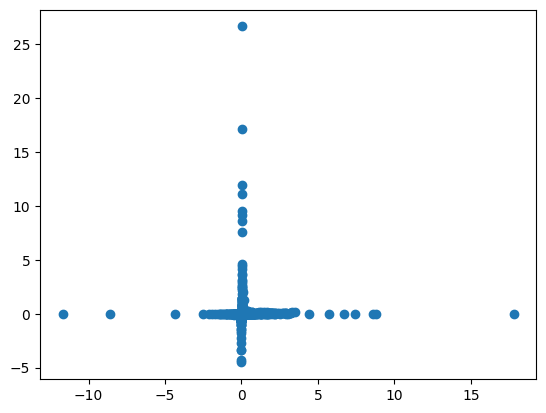

In [45]:
df["P/E"] = df["Price"] / (df["DilutedEPS"]*1000)
df["ROA"] = df["NetIncome"]*1000 / (df["TotalAssets"]*1000)
df['P/S'] = (df['Price'] * df['OrdinarySharesNumber']) / (df['TotalRevenue']*1000)
df['P/B'] = df['Price'] / (df['StockholdersEquity']*1000 / df['OrdinarySharesNumber'])
display(df)
plt.scatter(df["P/E"].to_list(), df["ROA"].to_list())
plt.show()

### Scaling

In [46]:
scaler = StandardScaler()
for column in df.columns.drop(["Ticker", "Name", "Date", "Earn Index", "Price", "3M Future Change", "Sector", "Industry"]):
    scaler.fit(df[[column]])
    df[column] = scaler.transform(df[[column]])

ValueError: Input X contains infinity or a value too large for dtype('float64').

### Splitting

In [ ]:
pred_data = df.loc[df["Earn Index"] == 0].copy()
test_data  = df.loc[df["Earn Index"] == 1].copy()
train_data = df.loc[~df["Earn Index"].isin([0, 1])].copy()

pred_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
train_data.reset_index(drop=True, inplace=True)

if debugging:
    print('Prediction Data:')
    display(pred_data)
    print("Test Data:")
    display(test_data)
    print('Training Data:')
    display(train_data)

Prediction Data:


,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,DepletionIncomeStatement,OccupancyAndEquipment,ProfessionalExpenseAndContractServicesExpense,OtherNonInterestExpense,SecuritiesAmortization,ExciseTaxes,P/E,ROA,P/S,P/B
0,422,Eli Lilly and Company,2025-03-31,0.0,6,29,822.414185,NaN,-2.743284,0.165382,...,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-359.725077,1.447085,13669.272375,-59428.430482
1,169,Danske Bank A/S,2025-03-31,0.0,5,11,225.100006,NaN,0.084594,0.609182,...,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,13.079265,0.030723,2138.603854,76.640235
2,396,Jyske Bank A/S,2025-06-30,0.0,5,11,641.000000,NaN,0.084594,0.813252,...,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,7.646966,-0.007857,2231.147722,-711.816317
3,508,"Netflix, Inc.",2025-06-30,0.0,1,34,1339.130005,NaN,0.084594,-0.522508,...,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,71.676952,-3.362003,5935.764961,724.593621
4,671,Scandinavian Tobacco Group A/S,2025-03-31,0.0,3,104,91.503189,NaN,-0.043583,0.476042,...,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-6.412922,0.773700,249.050088,437.363216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490,117,CWLTH BANK FPO [CBA],2025-06-30,0.0,5,10,181.941757,NaN,-1.240646,1.297072,...,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,14.154310,0.178068,959.880626,439.778723
491,745,WORLDLINE,2025-06-30,0.0,9,95,3.585000,NaN,-0.940213,0.720132,...,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-0.143871,0.996987,4.561515,3.448919
492,402,Kinnevik AB ser. B,2025-06-30,0.0,5,6,83.680000,NaN,0.084594,-2.075807,...,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-13.182026,0.882246,66.734044,-50.574381
493,740,WASTE CONNECTIONS INC,2025-06-30,0.0,7,111,253.423737,NaN,0.076422,0.742322,...,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-20.881786,0.701812,302.374419,459.936958


Test Data:


,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,DepletionIncomeStatement,OccupancyAndEquipment,ProfessionalExpenseAndContractServicesExpense,OtherNonInterestExpense,SecuritiesAmortization,ExciseTaxes,P/E,ROA,P/S,P/B
0,56,BAE Systems PLC,2024-12-31,1.0,7,1,56.118683,0.451540,0.064474,-0.078708,...,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-11.680319,-0.445654,671.937948,-3352.068105
1,422,Eli Lilly and Company,2024-12-31,1.0,6,29,767.409790,0.044842,-5.435903,-0.245133,...,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,18.433141,19.089377,848.015484,-19112.318239
2,169,Danske Bank A/S,2024-12-31,1.0,5,11,191.397659,0.176085,0.026390,0.620277,...,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,1.551976,0.161220,139.360147,62.953806
3,112,Carlsberg B A/S,2024-12-31,1.0,3,12,669.612610,0.309414,-0.705836,0.121002,...,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,2.026198,4.287376,-197.143690,-1779.964929
4,396,Jyske Bank A/S,2025-03-31,1.0,5,11,551.000000,0.163339,0.084594,0.797797,...,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,6.838379,-0.008614,1918.573358,-623.439959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
640,402,Kinnevik AB ser. B,2025-03-31,1.0,5,6,70.440002,0.187961,0.084594,-2.075807,...,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-0.958766,4.502973,40.453105,-43.471371
641,428,LONDON STOCK EXCHANGE GROUP PLC,2024-12-31,1.0,5,37,11283.538086,0.027027,-0.232089,0.897652,...,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-996.448671,-0.032014,-77306.993574,29506.651002
642,272,FRESNILLO PLC ORD USD0.50,2024-12-31,1.0,0,71,621.149841,0.533387,-0.280740,1.252692,...,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-36.857174,0.595167,-2351.483543,-1999.308307
643,740,WASTE CONNECTIONS INC,2025-03-31,1.0,7,111,278.991486,-0.091643,0.072871,0.453852,...,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-21.295770,0.723618,325.690542,486.410883


Training Data:


,Ticker,Name,Date,Earn Index,Sector,Industry,Price,3M Future Change,TaxEffectOfUnusualItems,TaxRateForCalcs,...,DepletionIncomeStatement,OccupancyAndEquipment,ProfessionalExpenseAndContractServicesExpense,OtherNonInterestExpense,SecuritiesAmortization,ExciseTaxes,P/E,ROA,P/S,P/B
0,56,BAE Systems PLC,2023-12-31,3.0,7,1,54.674278,0.216240,-0.359883,0.032242,...,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-9.840609,-0.288500,853.353743,-2796.462269
1,56,BAE Systems PLC,2022-12-31,4.0,7,1,39.349594,0.171293,0.702914,-0.318681,...,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-5.200446,-0.079038,731.502227,-2302.682433
2,56,BAE Systems PLC,2021-12-31,5.0,7,1,26.875683,0.257805,0.257052,-0.078708,...,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-4.003170,-0.184325,614.849563,-954.391810
3,422,Eli Lilly and Company,2024-09-30,2.0,6,29,879.216187,-0.125086,-8.598070,2.240146,...,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-70.961890,-1.439063,33352.933953,-22443.755703
4,422,Eli Lilly and Company,2024-06-30,3.0,6,29,897.254944,-0.029119,-0.848636,-0.340206,...,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-767.387895,6.739189,39372.719645,-17799.348800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3207,262,FIRST QUANTUM MINERALS LTD,2024-09-30,2.0,0,25,18.440001,0.010846,0.052258,-0.411558,...,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-1.074429,0.871281,-67.562505,-182.451060
3208,262,FIRST QUANTUM MINERALS LTD,2024-06-30,3.0,0,25,17.969999,0.054535,-0.002832,-0.411558,...,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-0.991323,0.963192,-65.473929,-174.507936
3209,262,FIRST QUANTUM MINERALS LTD,2023-12-31,5.0,0,25,11.050000,0.317647,-3.160162,2.362191,...,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-0.445039,1.535002,-64.001030,-62.578489
3210,262,FIRST QUANTUM MINERALS LTD,2022-12-31,6.0,0,25,28.116659,0.098268,0.407792,0.365092,...,9.122090e-15,0.0,1.651962e-16,-8.171130e-17,3.819977e-15,0.0,-2.741076,0.294673,-230.072404,-176.895944


### Labeling

In [ ]:
training_columns = ["Ticker", "Earn Index", "Sector", "Industry", "P/E", "ROA", "P/S", "P/B"]
label_columns = ["3M Future Change"]
X_pred = pred_data[training_columns]
X_test = test_data[training_columns]
y_test = test_data[label_columns]
X_train = train_data[training_columns]
y_train = train_data[label_columns]
if debugging:
    print("X_pred:")
    display(X_pred)
    print("X_test:")
    display(X_test)
    print("y_test:")
    display(y_test)
    print("X_train:")
    display(X_train)
    print("y_train:")
    display(y_train)

X_pred:


,Ticker,Earn Index,Sector,Industry,P/E,ROA,P/S,P/B
0,422,0.0,6,29,-359.725077,1.447085,13669.272375,-59428.430482
1,169,0.0,5,11,13.079265,0.030723,2138.603854,76.640235
2,396,0.0,5,11,7.646966,-0.007857,2231.147722,-711.816317
3,508,0.0,1,34,71.676952,-3.362003,5935.764961,724.593621
4,671,0.0,3,104,-6.412922,0.773700,249.050088,437.363216
...,...,...,...,...,...,...,...,...
490,117,0.0,5,10,14.154310,0.178068,959.880626,439.778723
491,745,0.0,9,95,-0.143871,0.996987,4.561515,3.448919
492,402,0.0,5,6,-13.182026,0.882246,66.734044,-50.574381
493,740,0.0,7,111,-20.881786,0.701812,302.374419,459.936958


X_test:


,Ticker,Earn Index,Sector,Industry,P/E,ROA,P/S,P/B
0,56,1.0,7,1,-11.680319,-0.445654,671.937948,-3352.068105
1,422,1.0,6,29,18.433141,19.089377,848.015484,-19112.318239
2,169,1.0,5,11,1.551976,0.161220,139.360147,62.953806
3,112,1.0,3,12,2.026198,4.287376,-197.143690,-1779.964929
4,396,1.0,5,11,6.838379,-0.008614,1918.573358,-623.439959
...,...,...,...,...,...,...,...,...
640,402,1.0,5,6,-0.958766,4.502973,40.453105,-43.471371
641,428,1.0,5,37,-996.448671,-0.032014,-77306.993574,29506.651002
642,272,1.0,0,71,-36.857174,0.595167,-2351.483543,-1999.308307
643,740,1.0,7,111,-21.295770,0.723618,325.690542,486.410883


y_test:


,3M Future Change
0,0.451540
1,0.044842
2,0.176085
3,0.309414
4,0.163339
...,...
640,0.187961
641,0.027027
642,0.533387
643,-0.091643


X_train:


,Ticker,Earn Index,Sector,Industry,P/E,ROA,P/S,P/B
0,56,3.0,7,1,-9.840609,-0.288500,853.353743,-2796.462269
1,56,4.0,7,1,-5.200446,-0.079038,731.502227,-2302.682433
2,56,5.0,7,1,-4.003170,-0.184325,614.849563,-954.391810
3,422,2.0,6,29,-70.961890,-1.439063,33352.933953,-22443.755703
4,422,3.0,6,29,-767.387895,6.739189,39372.719645,-17799.348800
...,...,...,...,...,...,...,...,...
3207,262,2.0,0,25,-1.074429,0.871281,-67.562505,-182.451060
3208,262,3.0,0,25,-0.991323,0.963192,-65.473929,-174.507936
3209,262,5.0,0,25,-0.445039,1.535002,-64.001030,-62.578489
3210,262,6.0,0,25,-2.741076,0.294673,-230.072404,-176.895944


y_train:


,3M Future Change
0,0.216240
1,0.171293
2,0.257805
3,-0.125086
4,-0.029119
...,...
3207,0.010846
3208,0.054535
3209,0.317647
3210,0.098268


## Model Training

In [ ]:
if train_new_model:
    model = RandomForestRegressor(
        n_estimators=tree_amount,
        verbose=True
    )
    model.fit(X_train, y_train.values.ravel())

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    9.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:   16.1s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:   25.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:   36.3s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:   49.3s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:  1.1min


## Testing and benchmarking

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    0.3s


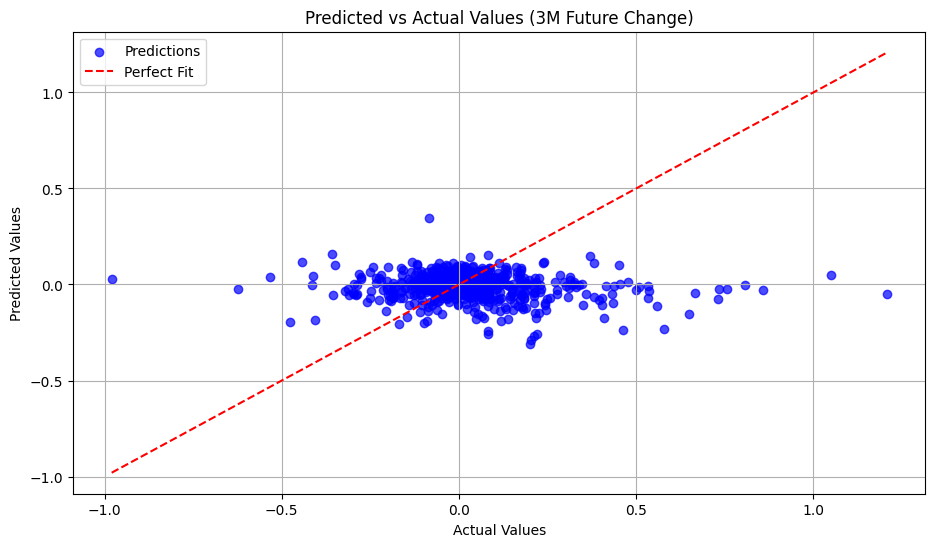

3M Future Change - R²: -0.2834
3M Future Change - MSE: 0.0446
3M Future Change - MAE: 0.1382

Overall Scores:
Mean - R²: -0.2834
Mean - MSE: 0.0446
Mean - MAE: 0.1382


In [ ]:
if train_new_model:
    y_test_pred = model.predict(X_test)
    for i, target in enumerate(['3M Future Change']):
        y_test_actual = y_test[target].values
        if getattr(y_test_pred, "ndim", 1) == 1:
            y_test_pred_target = y_test_pred
        else:
            y_test_pred_target = y_test_pred[:, i]

        plt.figure(figsize=(11, 6))
        plt.scatter(y_test_actual, y_test_pred_target, alpha=0.7, color='blue', label='Predictions')
        plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 
            color='red', linestyle='--', label='Perfect Fit')
        plt.title(f'Predicted vs Actual Values ({target})')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.legend()
        plt.grid(True)
        plt.show()

        mae = mean_absolute_error(y_test_actual, y_test_pred_target)
        mse = mean_squared_error(y_test_actual, y_test_pred_target)
        r2 = r2_score(y_test_actual, y_test_pred_target)

        print(f'{target} - R²: {r2:.4f}')
        print(f'{target} - MSE: {mse:.4f}')
        print(f'{target} - MAE: {mae:.4f}')

    # Overall metrics (single target)
    overall_pred = y_test_pred if getattr(y_test_pred, "ndim", 1) == 1 else y_test_pred[:, 0]
    mae = mean_absolute_error(y_test['3M Future Change'].values, overall_pred)
    mse = mean_squared_error(y_test['3M Future Change'].values, overall_pred)
    r2 = r2_score(y_test['3M Future Change'].values, overall_pred)

    print('\nOverall Scores:')
    print(f'Mean - R²: {r2:.4f}')
    print(f'Mean - MSE: {mse:.4f}')
    print(f'Mean - MAE: {mae:.4f}')

### Log test results

In [ ]:
if train_new_model:
    test_results = pd.DataFrame({
        'R²': r2,
        'MSE': mse,
        'MAE': mae,
        'symbol_list': symbol_list,
        "iterations": iterations,
        'hidden_layer_sizes': [model.model.hidden_layer_sizes],
        'max_iter': model.model.max_iter,
        'n_iter_no_change': model.model.n_iter_no_change,
        'learning_rate': model.model.learning_rate,
        'learning_rate_init': model.model.learning_rate_init,
        'batch_size': model.model.batch_size,
        'tol': model.model.tol,
        'alpha': model.model.alpha,
        'shuffle': model.model.shuffle,
    })
    test_results.to_csv('../data/model_results/test_results.csv', mode='a', index=False)

    # save model as new best if results are better than the current one
    best_r2 = pd.read_csv('../data/model_results/best_model_results.csv').loc[0, 'R²']
    if r2 > best_r2:
        print(f'Old best R²: {best_r2}')
        print(f'New best R²: {r2}')
        print('Saving new best model...')
        test_results.to_csv('../data/model_results/best_model_results.csv', mode='w', index=False)
        with open('../models/best_model.pkl','wb') as f:
            pickle.dump(model,f)
        

NameError: name 'iterations' is not defined

## Predictions on latest data

In [ ]:
best_r2 = pd.read_csv('../data/model_results/best_model_results.csv').loc[0, 'R²']

with open('../models/best_model.pkl', 'rb') as f:
    model = pickle.load(f)
    print(f'Best model R²: {best_r2}')


FileNotFoundError: [Errno 2] No such file or directory: '../models/best_model.pkl'

In [ ]:
df_raw = pd.read_csv('../data/model_results/earnings_data.csv')

results = []
for i in range(len(X_pred)):
    y_pred = model.predict(X_pred.iloc[[i]])[0]
    y_pred_3m, y_pred_6m, y_pred_9m, y_pred_1y = y_pred
    avg = (y_pred_3m + y_pred_6m + y_pred_9m + y_pred_1y) / 4
    results.append({
        'Ticker': df_raw.loc[i*4, 'Ticker'],
        'Name': df_raw.loc[i*4, 'Name'],
        'mean (%)': avg * 100,
        '3m (%)': y_pred_3m * 100,
        '6m (%)': y_pred_6m * 100,
        '9m (%)': y_pred_9m * 100,
        '1y (%)': y_pred_1y * 100
    })

results_df = pd.DataFrame(results)
results_df

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- ExciseTaxes


In [ ]:
def predict_ticker(ticker_str):
    try:
        ticker_str = str(ticker_str).upper()
        ticker_str = ticker_str.replace("'", "")
        ticker_str = ticker_str.replace('"', "")
        row = results_df[results_df['Ticker'] == ticker_str]
        if row.empty:
            return (f"Not enough data for this stock at this moment \n Try another", "", "", "", "")
        row = row.iloc[0]
        return (
            f"{row['3m (%)']:.2f}",
            f"{row['6m (%)']:.2f}",
            f"{row['9m (%)']:.2f}",
            f"{row['1y (%)']:.2f}",
            f"{row['mean (%)']:.2f}",
        )
    except Exception as e:
        return (f"Error: {e}", "", "", "", "")

In [ ]:
iface = gr.Interface(
    fn=predict_ticker,
    inputs=gr.Textbox(label="Ticker e.g. 'TSLA' or 'NVDA'"),
    outputs=[
        gr.Textbox(label="3 Month Change Prediction (%)"),
        gr.Textbox(label="6 Month Change Prediction (%)"),
        gr.Textbox(label="9 Month Change Prediction (%)"),
        gr.Textbox(label="1 Year Change Prediction (%)"),
        gr.Textbox(label="Mean Change Prediction (%)"),
    ],
    title="Stock Price Prediction Model",
    description=" "
)

iface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://d6f7567b4876962a6e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
